In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from itertools import combinations 
import seaborn as sns
from cartopy import crs as ccrs, feature as cfeature

plt.rcParams['figure.dpi'] = 400

In [5]:
means = []
combo1 = []
combo2 = []
cities = ["Jaffna", "Nallur", "Navanthurai","Kokkuvil", "Uduvil", "Mankumban", "Kopay",  "Inuvil", "Gurunagar", "Ariyalai"][::-1]
for combo in combinations(cities, 2): 
    try:
        fst = pd.read_csv(f"../data/fst/{combo[0]}{combo[1]}.txt.weir.fst", sep="\t")
    except FileNotFoundError as not_found: 
        fst = pd.read_csv(f"../data/fst/{combo[1]}{combo[0]}.txt.weir.fst", sep="\t")
    mean = fst["WEIR_AND_COCKERHAM_FST"].mean() if fst["WEIR_AND_COCKERHAM_FST"].mean() > 0 else 0
    means.append(mean)
    combo1.append(combo[0])
    combo2.append(combo[1])

pairfst = pd.DataFrame({"Population 1":combo1, "Population 2":combo2, "fst mean":means})
pairfst["fst mean"] = pairfst["fst mean"].round(2)
pairfst["Population 2"] = pd.Categorical(pairfst["Population 2"], cities)
pairfst["Population 1"] = pd.Categorical(pairfst["Population 1"], cities)

pairfst['Population 1'] = pairfst['Population 1'].replace('Jaffna', 'Jaffna City')
pairfst['Population 2'] = pairfst['Population 2'].replace('Jaffna', 'Jaffna City')

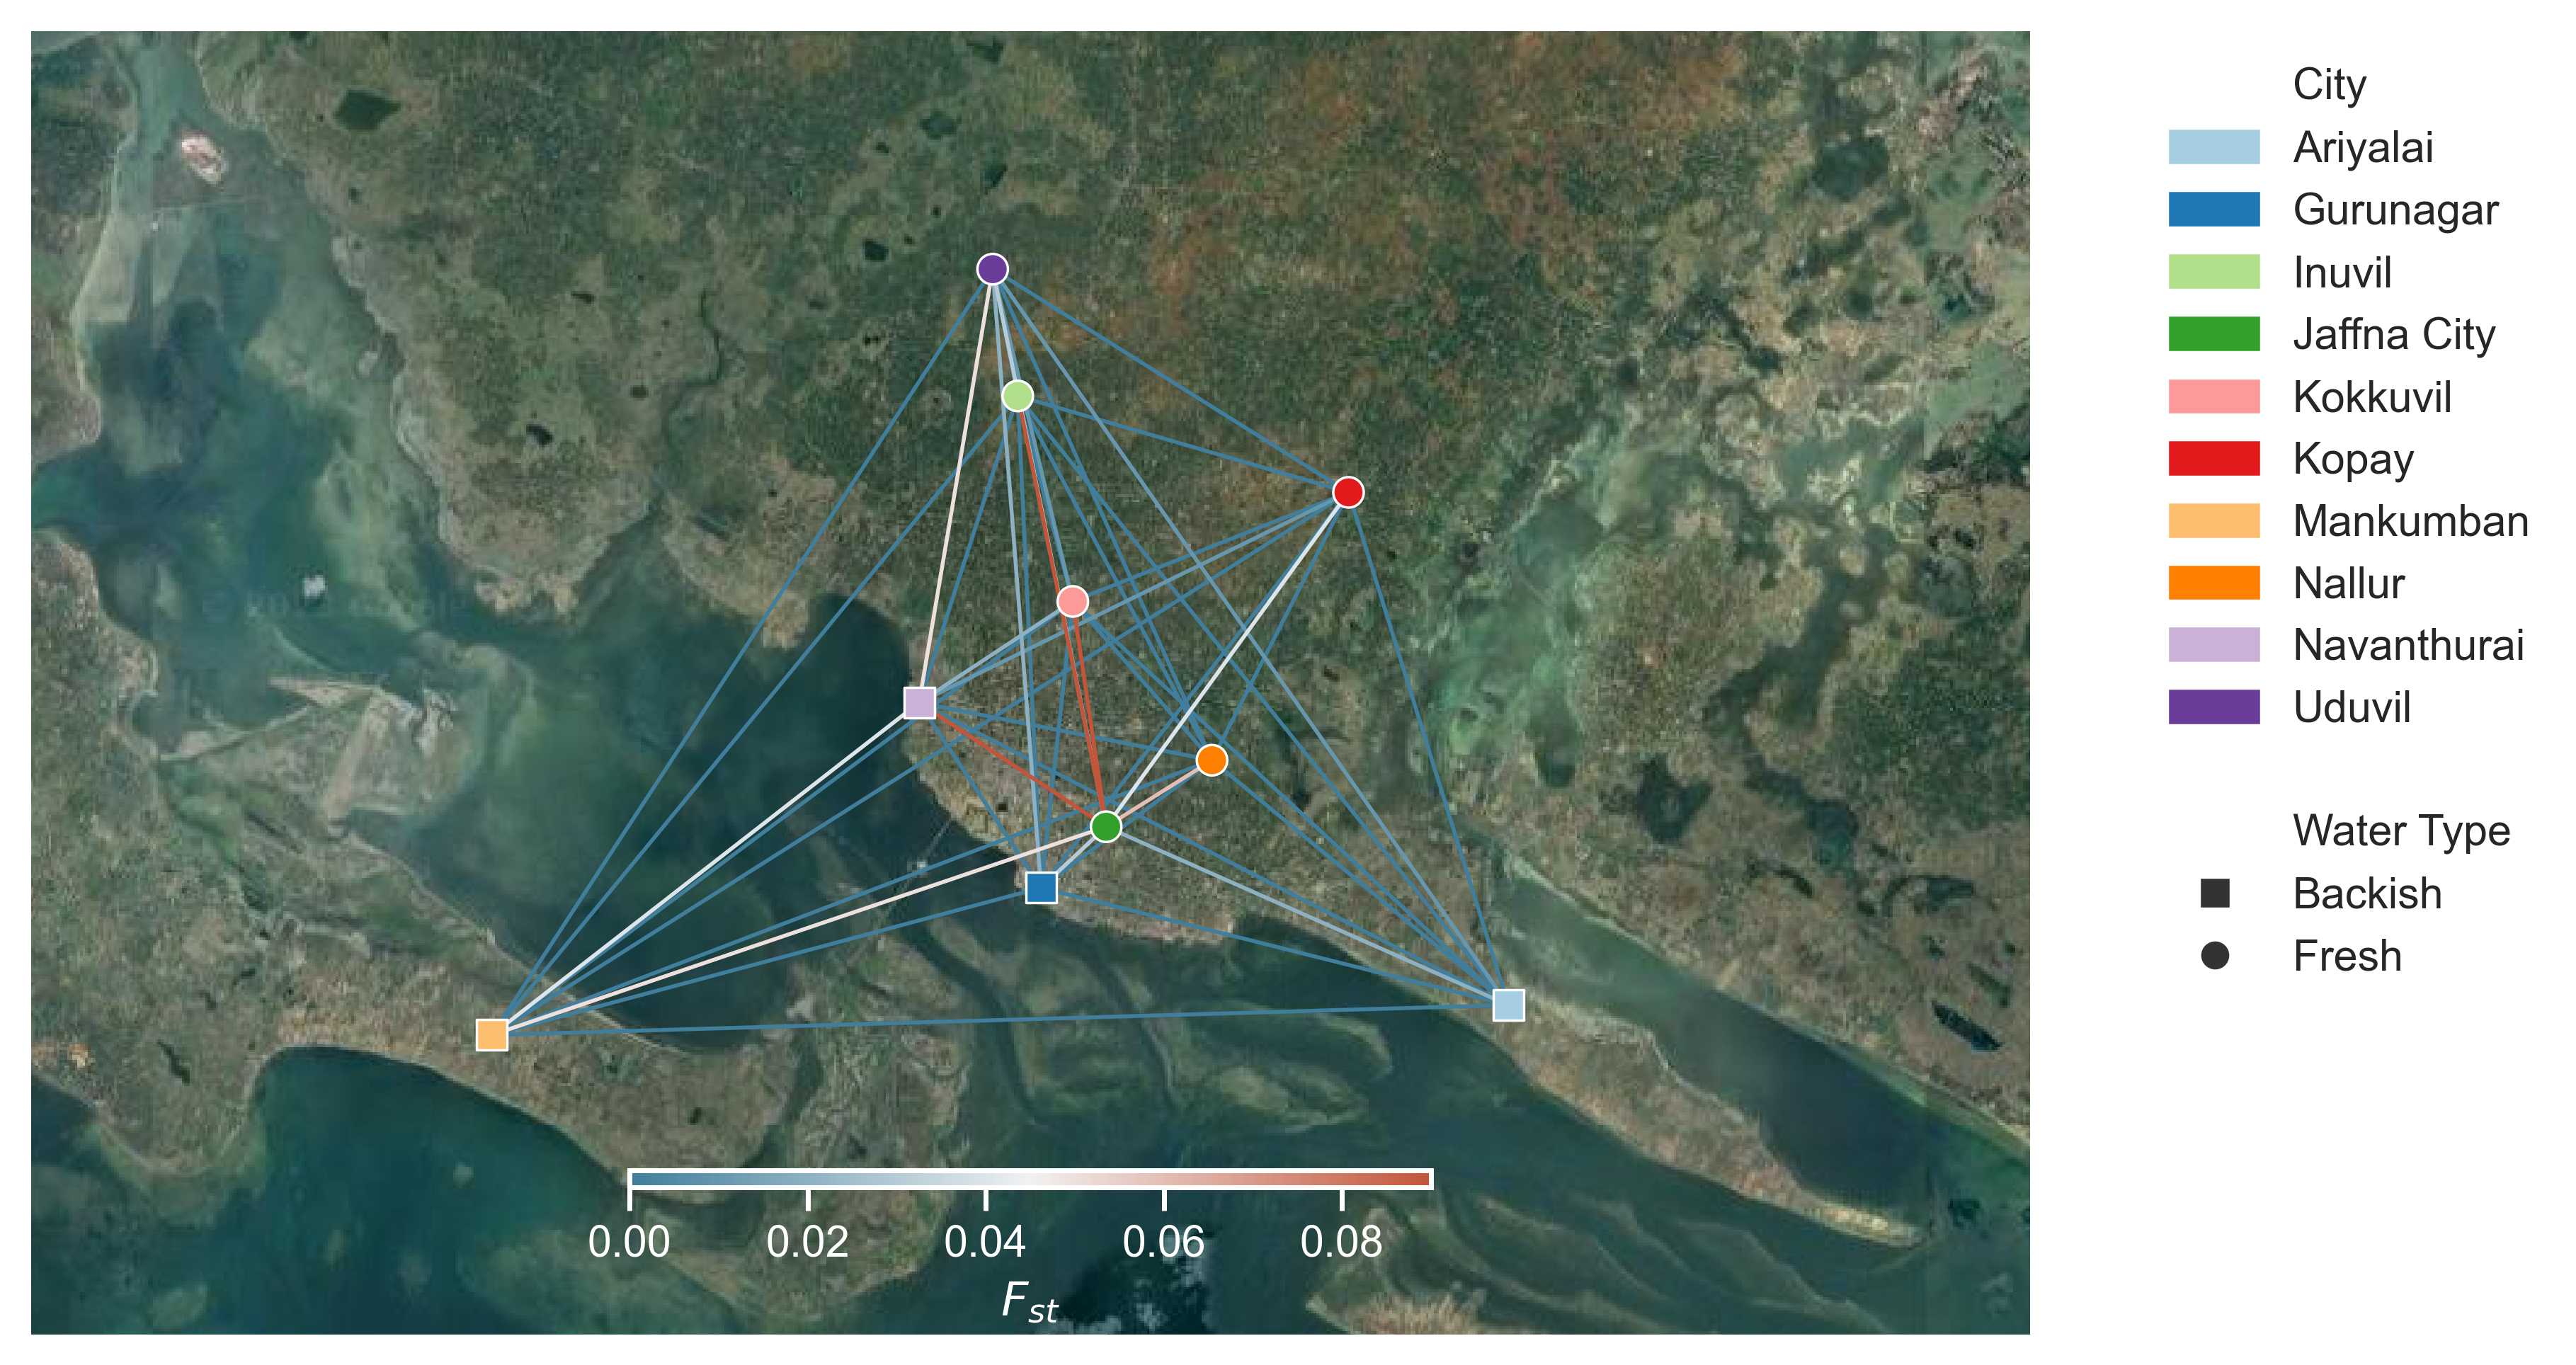

In [6]:
import matplotlib.patches as mpatches

sns.set(rc = {'figure.figsize':(10,6)})
lons = [80.0786359, 80.01695029999999, 80.0008524,80.02554649999999,  
         79.94445259999999, 80.0395205, 80.021143,80.01056179999999, 80.05754,80.01387659467527]
lats = [9.6382902, 9.6535589, 9.677645799999999, 9.6614981, 9.6343901, 9.670154700000001, 9.690824, 9.7340655,9.705016,  9.717561538315094]
locations = ["Ariyalai", "Gurunagar", "Navanthurai", "Jaffna City", "Mankumban", "Nallur", "Kokkuvil", "Uduvil", "Kopay", "Inuvil"]
is_salinty = ['Backish', 'Backish', 'Backish', 'Fresh', 'Backish', 'Fresh', 'Fresh', 'Fresh', 'Fresh', 'Fresh']
locs = pd.DataFrame({"logitude": lons, "latitudes": lats, "names": locations, "salinity": is_salinty})
locs = locs.sort_values(by="names")
location_dict = {locations[i]: [lons[i], lats[i]] for i in range(len(locations))}

latN = 9.7654
latS = 9.59512
lonW = 79.88326
lonE = 80.14779
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2

import cartopy.io.img_tiles as cimgt

fig = plt.figure()
request = cimgt.GoogleTiles(style="satellite")
ax = plt.axes(projection=request.crs)
ax.set_extent([lonW, lonE, latS, latN])
# add google maps
ax.add_image(request, 12)

# add sample location
cmap = sns.diverging_palette(230, 20, as_cmap=True)
max_fst = max(pairfst["fst mean"])
min_fst = min(pairfst["fst mean"])
for i, row in pairfst.sort_values(by="fst mean").iterrows():
    if row["Population 1"] != row["Population 2"]:
        cor1 = location_dict[row["Population 2"]]
        cor2 = location_dict[row["Population 1"]]
        frac_total = (row["fst mean"] - min_fst) / (max_fst+abs(min_fst))
        ax.plot([cor1[0], cor2[0]], [cor1[1], cor2[1]], transform=ccrs.PlateCarree(), color=cmap(frac_total), linewidth=1)

sns.set_palette("Paired")
ax = sns.scatterplot(data=locs, x="logitude", y="latitudes", transform=ccrs.PlateCarree(), ax=ax, zorder=99, style="salinity", hue="names", s=60, markers=["s", "o"])

# make the custom legend
legends = ax.legend()
custom_legend = [mpatches.Patch(color="white", label="City")]
for j, obj in enumerate(legends.get_texts()[1:11]):
    custom_legend.append(mpatches.Patch(color=sns.color_palette("Paired")[j], label=obj.get_text()))
handles, labels = ax.get_legend_handles_labels()

custom_legend.append(mpatches.Patch(color="white", label=""))
custom_legend.append(mpatches.Patch(color="white", label="Water Type"))
custom_legend.append(handles[-2])
custom_legend.append(handles[-1])

ax.legend(handles=custom_legend, frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))


# add colorbar
l, b, w, h = ax.get_position().bounds
cax = fig.add_axes([l + (w * 0.6)/2, # adjustment so it is centered 
                    b + (b* 0.8), #increasing makes go higher 
                    w * 0.4, # width
                    0.01])
norm = mpl.colors.Normalize(vmin=min_fst, vmax=max_fst)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal')
cb.set_label(color="white", label='$F_{st}$')
# set colorbar tick color
cb.ax.yaxis.set_tick_params(color="white")
# set colorbar edgecolor 
cb.outline.set_edgecolor("white")
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="white")
cb.ax.xaxis.set_tick_params(color="white")
# cb.set_label(color="white", label='$f_{st}$')


# norm = mpl.colors.Normalize(vmin=min_fst, vmax=max_fst)
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal', label='Some Units')
plt.show()
